This Notebook is a modified version of the pytorch tutorial from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. It has been modified form the original to implements, train and test a multi-layer perceptron (MLP) instead of a CNN.



# Useful Resources

**Books:**
- Dive into Deep Learning (https://d2l.ai/index.html) (Practical Book)
- Deep Learning by Ian Goodfellow, Yoshua Bengio, Aaron Courville (https://www.deeplearningbook.org/) (Theoritical Book)
- Understanding Deep Learning by Simon J.D. Prince (https://udlbook.github.io/udlbook/) (Theoritical Book)
- Deep Learning with PyTorch by Eli Stevens, Luca Antiga, and Thomas Viehmann (Practical+Theoritical Book)
- Machine Learning Yearning Book by Andrew Ng (https://info.deeplearning.ai/machine-learning-yearning-book) (Give you at least 1 year of experience instantly)

**Github repo**:
- https://github.com/ChristosChristofidis/awesome-deep-learning
- https://github.com/ashishpatel26/500-AI-Machine-learning-Deep-learning-Computer-vision-NLP-Projects-with-code

**Interview Preparation**
- Machine Learning Interviews by Chip Huyen (https://huyenchip.com/ml-interviews-book/) (Super helpful if you are aiming for FAANG-like companies or joining a start-up, many good advices & insights)
- Deep Learning Interviews: Hundreds of fully solved job interview questions from a wide range of key topics in AI (https://arxiv.org/abs/2201.00650), by Shlomo Kashani, Amir Ivry
- Cracking the Coding Interview by Gayle Laakmann McDowell (Crucial for preparing coding interviews)

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

## What about data?

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For <font color='red'>images</font>, packages such as Pillow, OpenCV are useful
-  For <font color='blue'>audio</font>, packages such as scipy and librosa
-  For <font color='green'>text</font>, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for <font color='red'>**vision**</font>, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the `CIFAR10 dataset`.
It has the classes: `‘airplane’`, `‘automobile’`, `‘bird’`, `‘cat’`, `‘deer’`,
`‘dog’`, `‘frog’`, `‘horse’`, `‘ship’`, `‘truck’`. The images in CIFAR-10 are of
size `3x32x32`, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## Training an image classifier

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Convert img to Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (mean_red, mean_green, mean_blue), (stdev_red, stdev_green, stdev_blue)

batch_size = 4 # The number of images is used at one step.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



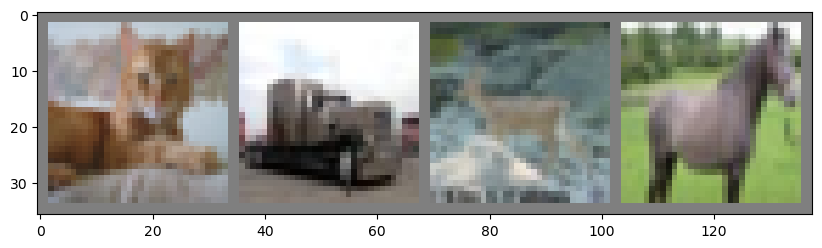

cat   truck deer  horse


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img, figsize=(10, 10)):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Multilayer Perceptron Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
              nn.Linear(32*32*3, 512),
              nn.ReLU(),
              nn.Linear(512, 512),
              nn.ReLU(),
              nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x


net = Net()

In [9]:
net

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

Information about Classification Cross-Entropy loss 
https://wandb.ai/sauravmaheshkar/cross-entropy/reports/What-Is-Cross-Entropy-Loss-A-Tutorial-With-Code--VmlldzoxMDA5NTMx

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
n_epochs = 2 # Number of epochs

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [15]:
for epoch in range(n_epochs):  # loop over the dataset multiple times
    print(f"-----EPOCH {epoch+1}-----")
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

-----EPOCH 1-----
[1,  2000] loss: 1.083
[1,  4000] loss: 1.101
[1,  6000] loss: 1.114
[1,  8000] loss: 1.117
[1, 10000] loss: 1.126
[1, 12000] loss: 1.122
-----EPOCH 2-----
[2,  2000] loss: 0.985
[2,  4000] loss: 1.022
[2,  6000] loss: 1.033
[2,  8000] loss: 1.026
[2, 10000] loss: 1.064
[2, 12000] loss: 1.051
Finished Training


Let's quickly save our trained model:



In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



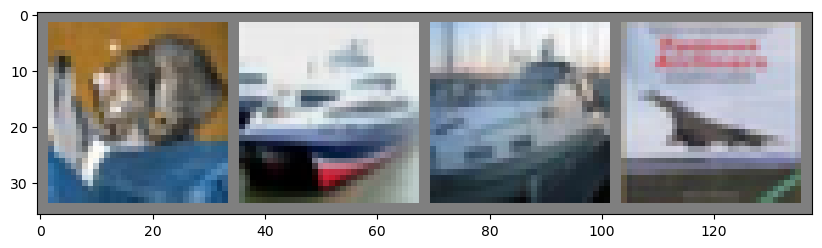

GroundTruth:  cat   ship  ship  plane


In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [19]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   truck ship  deer 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 56.6 %
Accuracy for class: car   is 57.4 %
Accuracy for class: bird  is 42.1 %
Accuracy for class: cat   is 40.2 %
Accuracy for class: deer  is 37.0 %
Accuracy for class: dog   is 35.6 %
Accuracy for class: frog  is 70.0 %
Accuracy for class: horse is 66.8 %
Accuracy for class: ship  is 74.3 %
Accuracy for class: truck is 56.0 %


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Training on multiple GPUs
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

## Where do I go next?

-  `Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
del dataiter